# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the Model](#build)
3. [Train the Model](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

import os
import glob
import json
from pprint import pprint
import random
import re
import time
from fractions import Fraction
import string
from IPython.display import display, HTML

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

import music21

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from utils.music import parse_midi_files, create_lookup_tables, load_parsed_files

2022-10-24 16:50:03.403295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0. Parameters <a name="parameters"></a>

In [49]:
PARSE_MIDI_FILES = True
DATASET_REPETITIONS = 1

MAX_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 50
BATCH_SIZE = 256

## 1. Prepare the Data

In [3]:
# Load the data
file_list = glob.glob('/app/data/bach-cello/*.mid')
print(f'Found {len(file_list)} midi files')

Found 36 midi files


In [4]:
parser = music21.converter

In [8]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(file_list, parser, MAX_LEN + 1)
else:
    notes, durations = load_parsed_files()

1 Parsing /app/data/bach-cello/cs1-1pre.mid
2 Parsing /app/data/bach-cello/cs1-2all.mid
3 Parsing /app/data/bach-cello/cs1-3cou.mid
4 Parsing /app/data/bach-cello/cs1-4sar.mid
5 Parsing /app/data/bach-cello/cs1-5men.mid
6 Parsing /app/data/bach-cello/cs1-6gig.mid
7 Parsing /app/data/bach-cello/cs2-1pre.mid
8 Parsing /app/data/bach-cello/cs2-2all.mid
9 Parsing /app/data/bach-cello/cs2-3cou.mid
10 Parsing /app/data/bach-cello/cs2-4sar.mid
11 Parsing /app/data/bach-cello/cs2-5men.mid
12 Parsing /app/data/bach-cello/cs2-6gig.mid
13 Parsing /app/data/bach-cello/cs3-1pre.mid
14 Parsing /app/data/bach-cello/cs3-2all.mid
15 Parsing /app/data/bach-cello/cs3-3cou.mid
16 Parsing /app/data/bach-cello/cs3-4sar.mid
17 Parsing /app/data/bach-cello/cs3-5bou.mid
18 Parsing /app/data/bach-cello/cs3-6gig.mid
19 Parsing /app/data/bach-cello/cs4-1pre.mid
20 Parsing /app/data/bach-cello/cs4-2all.mid
21 Parsing /app/data/bach-cello/cs4-3cou.mid
22 Parsing /app/data/bach-cello/cs4-4sar.mid
23 Parsing /app/dat

In [9]:
# Display an example of a string of notes
example_notes = notes[0]
print(example_notes)

START G2 D3 B3 A3 B3 D3 B3 D3 G2 D3 B3 A3 B3 D3 B3 D3 G2 E3 C4 B3 C4 E3 C4 E3 G2 E3 C4 B3 C4 E3 C4 E3 G2 F#3 C4 B3 C4 F#3 C4 F#3 G2 F#3 C4 B3 C4 F#3 C4 F#3 G2 G3


In [10]:
# Display an example of a string of durations
example_durations = durations[0]
print(example_durations)

0 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


## 2. Tokenize the data <a name="tokenize"></a>

In [50]:
def create_dataset(elements):
    # Convert to a Tensorflow Dataset
    ds = tf.data.Dataset.from_tensor_slices(elements).batch(BATCH_SIZE, drop_remainder = True).shuffle(1000)
    # Create vectorisation layers
    vectorize_layer = keras.layers.TextVectorization(
        standardize = None,
        output_mode="int",
    )
    # Adapt the layer to the training set
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab

In [51]:
notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
notes_vocab_size = len(notes_vocab)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(durations)
durations_vocab_size = len(durations_vocab)

In [52]:
# Display some token:note mappings
for i, note in enumerate(notes_vocab[:10]):
    print(f'{i}: {note}')

0: 
1: [UNK]
2: G3
3: D3
4: A3
5: F3
6: C4
7: E3
8: D4
9: B3


In [53]:
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:100]):
    print(f'{i}: {note}')

0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6
10: 2.0
11: 3.0
12: 0
13: 1.25
14: 2.5
15: 4/3
16: 4.0
17: 2/3
18: 3.75
19: 5.5
20: 3.5
21: 3.25
22: 2.75
23: 1.75


In [54]:
# Display the same example notes converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
print(example_tokenised_notes.numpy())

[45 15  3  9  4  9  3  9  3 15  3  9  4  9  3  9  3 15  7  6  9  6  7  6
  7 15  7  6  9  6  7  6  7 15 11  6  9  6 11  6 11 15 11  6  9  6 11  6
 11 15  2]


In [55]:
# Display the same example durations converted to ints
example_tokenised_durations = durations_vectorize_layer(example_durations)
print(example_tokenised_durations.numpy())

[12  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2]


## 3. Create the Training Set <a name="create"></a>

In [56]:
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [57]:
# Create the training set of pieces and the same pieces shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1],  tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y

ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [58]:
example_input_output = ds.take(1).get_single_element()

## 5. Create the causal attention mask function <a name="causal"></a>

In [59]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

np.transpose(causal_attention_mask(1, 10,10,dtype = tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [60]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, name, dropout_rate=0.1):
        super(TransformerBlock, self).__init__(name = name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = keras.layers.MultiHeadAttention(num_heads, key_dim, output_shape = embed_dim)
        self.dropout_1 = keras.layers.Dropout(self.dropout_rate)
        self.ln_1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = keras.layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = keras.layers.Dense(self.embed_dim)
        self.dropout_2 = keras.layers.Dropout(self.dropout_rate)
        self.ln_2 = keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output, attention_scores = self.attn(inputs, inputs, attention_mask=causal_mask, return_attention_scores=True)
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "key_dim": self.key_dim,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [61]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len =max_len
        self.vocab_size =vocab_size
        self.embed_dim = embed_dim
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = keras.layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "max_len": self.max_len,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [62]:
note_inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(MAX_LEN, notes_vocab_size, EMBEDDING_DIM)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(MAX_LEN, durations_vocab_size, EMBEDDING_DIM)(durations_inputs)
embeddings = keras.layers.Add()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name = 'attention')(embeddings)
note_outputs = keras.layers.Dense(notes_vocab_size, activation = 'softmax', name = 'note_outputs' )(x)
duration_outputs = keras.layers.Dense(durations_vocab_size, activation = 'softmax' , name = 'duration_outputs')(x)
model = keras.Model(
    inputs=[note_inputs, durations_inputs]
    , outputs=[note_outputs, duration_outputs] #attention_scores
)
model.compile("adam"
              , loss=[keras.losses.SparseCategoricalCrossentropy(), keras.losses.SparseCategoricalCrossentropy()]
             )
att_model = keras.Model(
    inputs=[note_inputs, durations_inputs]
    , outputs=attention_scores
)

In [63]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_4  (None, None, 256)   133888      ['input_5[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 token_and_position_embedding_5  (None, None, 256)   18944       ['input_6[0][0]']          

In [64]:
if LOAD_MODEL:
    # model.load_weights('./models/model')
    model = keras.models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [65]:
# Create a MusicGenerator checkpoint
class MusicGenerator(keras.callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {note: index for index, note in enumerate(index_to_note)}
        self.index_to_duration = index_to_duration
        self.duration_to_index = {duration: index for index, duration in enumerate(index_to_duration)}
        
    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs 
    
    def generate(self, start_notes, start_durations, max_tokens, temperature):
        
        attention_model = keras.Model(inputs=self.model.input, outputs=self.model.get_layer('attention').output)
        
        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [self.duration_to_index.get(x, 1) for x in start_durations]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()
        
        midi_stream.append(music21.clef.BassClef())
    
        while len(start_note_tokens) < max_tokens and sample_note != 0:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1,x2], verbose = 0)
            _, att = attention_model.predict([x1,x2], verbose = 0)
            sample_note_idx = 1
            while sample_note_idx == 1:
                sample_note_idx, note_probs = self.sample_from(notes[0][-1], temperature)
            sample_duration_idx = 1
            while sample_duration_idx == 1:
                sample_duration_idx, duration_probs = self.sample_from(durations[0][-1], temperature)
            sample_note = self.index_to_note[sample_note_idx]
            sample_duration = self.index_to_duration[sample_duration_idx]
            
            if "." in sample_note:
                notes_in_chord = sample_note.split(".")
                chord_notes = []
                for current_note in notes_in_chord:
                    new_note = music21.note.Note(current_note)
                    new_note.duration = music21.duration.Duration(float(Fraction(sample_duration)))
                    new_note.storedInstrument = music21.instrument.Violoncello()
                    chord_notes.append(new_note)
                new_chord = music21.chord.Chord(chord_notes)
                midi_stream.append(new_chord)
            elif sample_note == "rest":
                new_note = music21.note.Rest()
                new_note.duration = music21.duration.Duration(float(Fraction(sample_duration)))
                new_note.storedInstrument = music21.instrument.Violoncello()
                midi_stream.append(new_note)
            elif sample_note != "START":
                new_note = music21.note.Note(sample_note)
                new_note.duration = music21.duration.Duration(float(Fraction(sample_duration)))
                new_note.storedInstrument = music21.instrument.Violoncello()
                midi_stream.append(new_note)

            info.append({
                'prompt': [start_notes.copy(), start_durations.copy()] 
                , 'midi': midi_stream
                , 'note_probs': note_probs
                , 'duration_probs': duration_probs
                , 'atts': att[0,:,-1,:]
            })
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)
        
        return info
        
    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(["START"], ["0"], max_tokens = MAX_LEN, temperature = 1.0)
        midi_stream = info[-1]['midi'].chordify()
        midi_stream.show()
        midi_stream.write("midi", fp=os.path.join('/app/notebooks/music/bach-cello/output', "output-" + str(epoch) + ".mid"))
        

In [66]:
# Create a model save checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 4.6738 - note_outputs_loss: 3.8632 - duration_outputs_loss: 0.8105

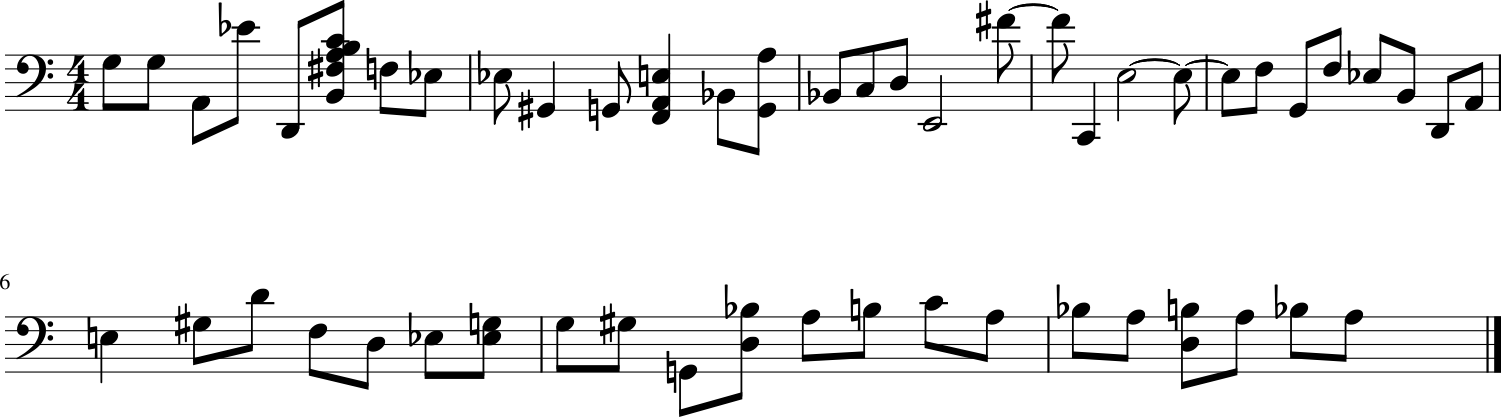

107/107 [==============================] - 124s 1s/step - loss: 4.6738 - note_outputs_loss: 3.8632 - duration_outputs_loss: 0.8105
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 3.7469 - note_outputs_loss: 3.0900 - duration_outputs_loss: 0.6569

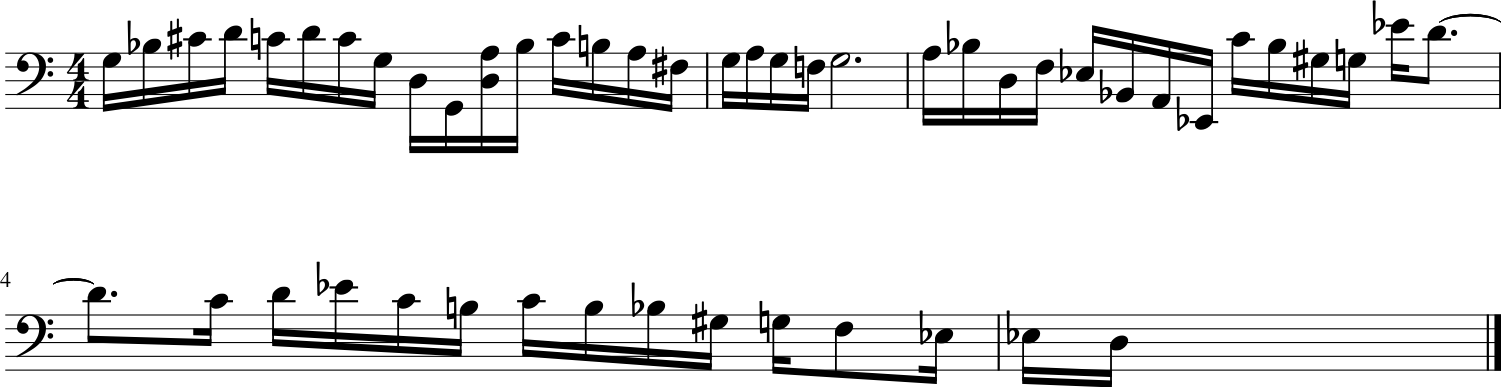

107/107 [==============================] - 101s 942ms/step - loss: 3.7469 - note_outputs_loss: 3.0900 - duration_outputs_loss: 0.6569
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 3.3874 - note_outputs_loss: 2.7602 - duration_outputs_loss: 0.6271

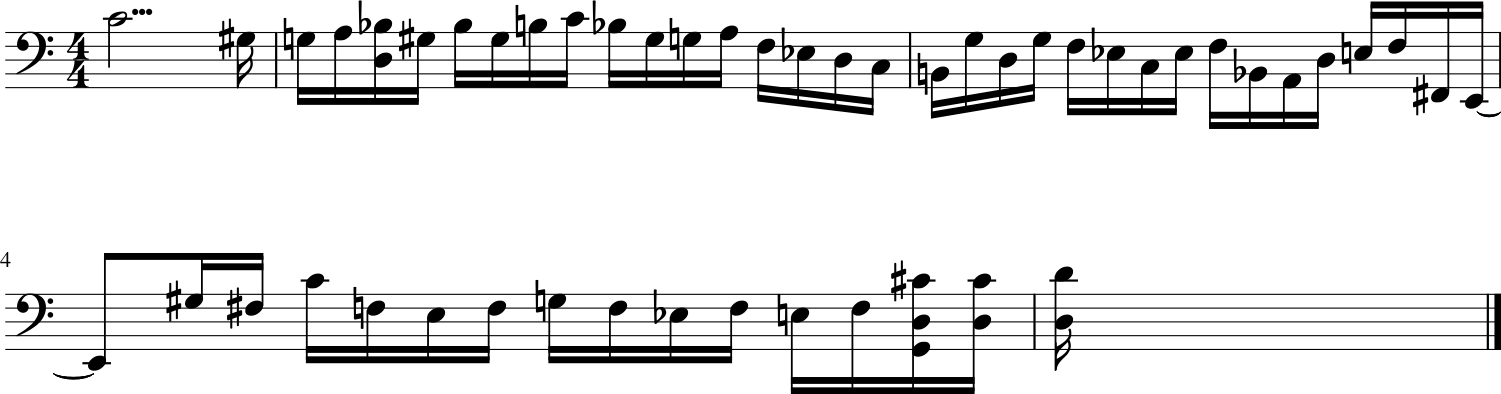

107/107 [==============================] - 106s 989ms/step - loss: 3.3874 - note_outputs_loss: 2.7602 - duration_outputs_loss: 0.6271
Epoch 4/50
107/107 [==============================] - ETA: 0s - loss: 3.2323 - note_outputs_loss: 2.6317 - duration_outputs_loss: 0.6006

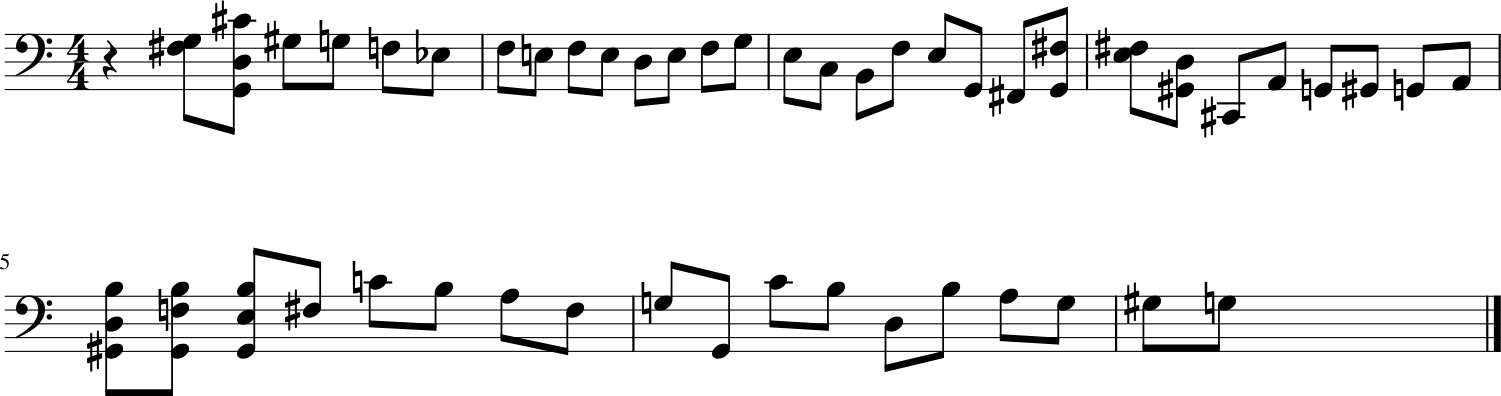

107/107 [==============================] - 83s 773ms/step - loss: 3.2323 - note_outputs_loss: 2.6317 - duration_outputs_loss: 0.6006
Epoch 5/50
107/107 [==============================] - ETA: 0s - loss: 3.1295 - note_outputs_loss: 2.5323 - duration_outputs_loss: 0.5973

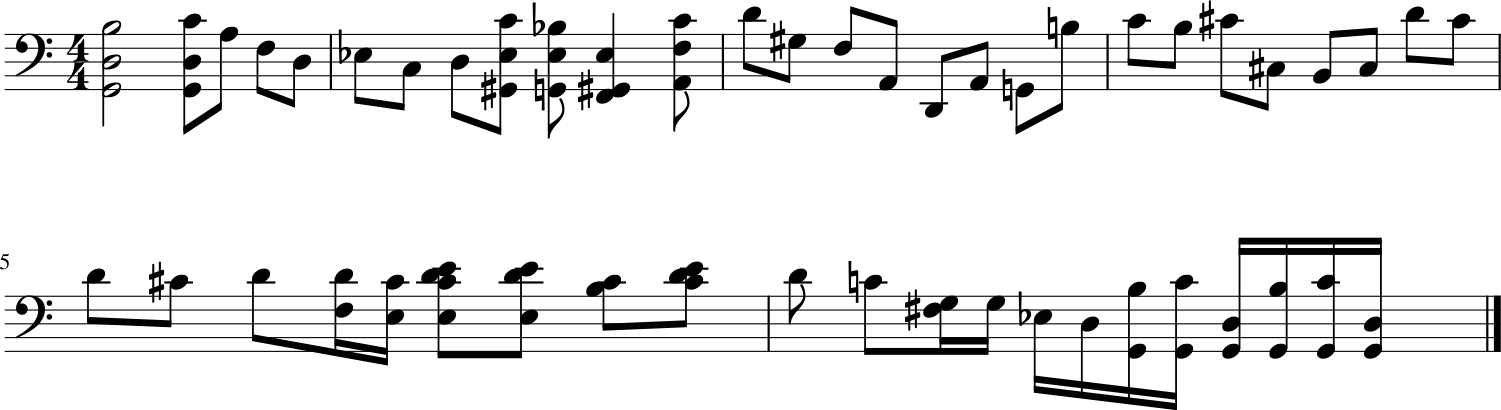

107/107 [==============================] - 80s 748ms/step - loss: 3.1295 - note_outputs_loss: 2.5323 - duration_outputs_loss: 0.5973
Epoch 6/50
107/107 [==============================] - ETA: 0s - loss: 3.0949 - note_outputs_loss: 2.4814 - duration_outputs_loss: 0.6134

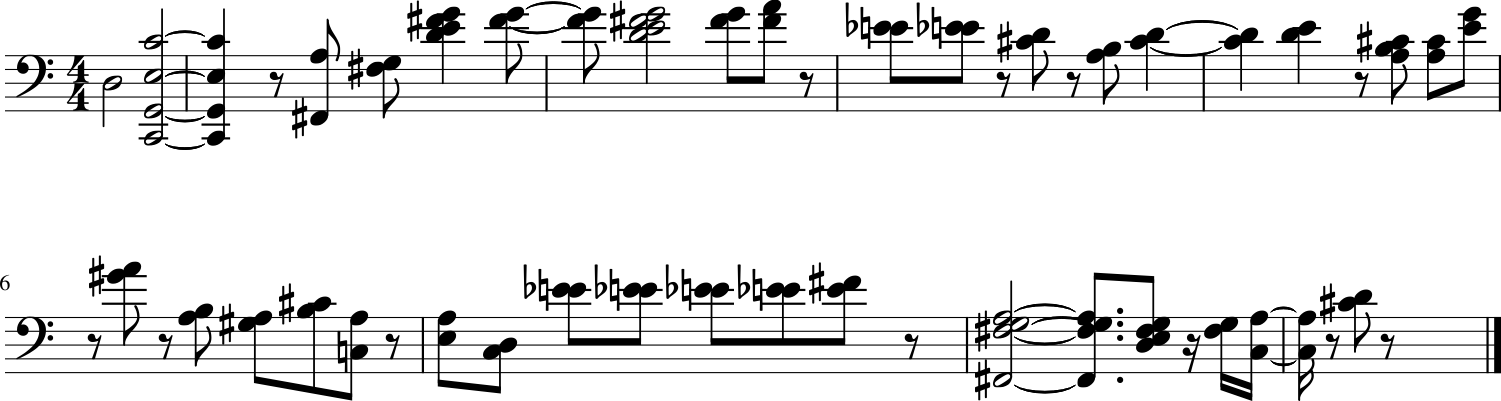

107/107 [==============================] - 80s 752ms/step - loss: 3.0949 - note_outputs_loss: 2.4814 - duration_outputs_loss: 0.6134
Epoch 7/50
107/107 [==============================] - ETA: 0s - loss: 2.9917 - note_outputs_loss: 2.4097 - duration_outputs_loss: 0.5821

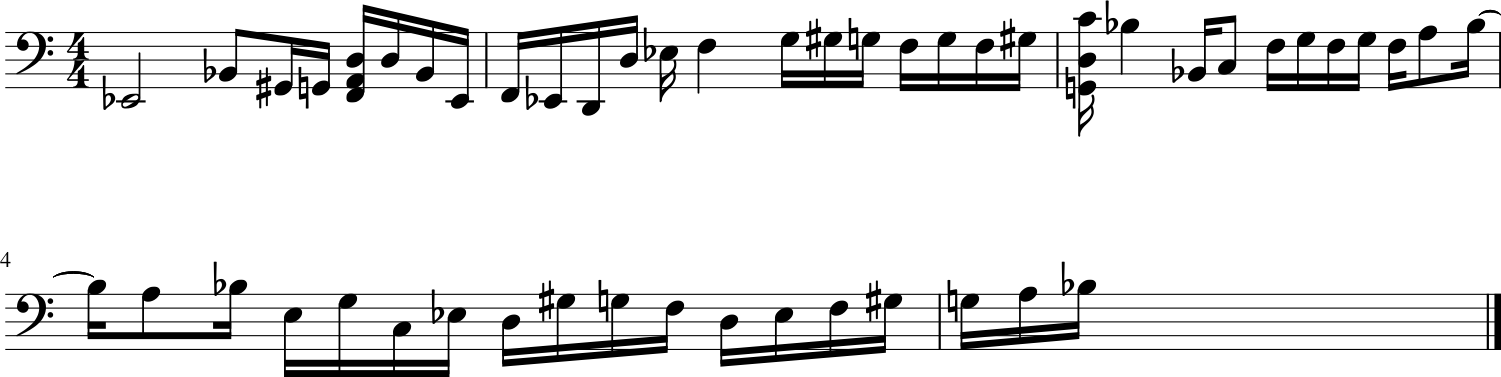

107/107 [==============================] - 85s 792ms/step - loss: 2.9917 - note_outputs_loss: 2.4097 - duration_outputs_loss: 0.5821
Epoch 8/50
107/107 [==============================] - ETA: 0s - loss: 2.9508 - note_outputs_loss: 2.3653 - duration_outputs_loss: 0.5855

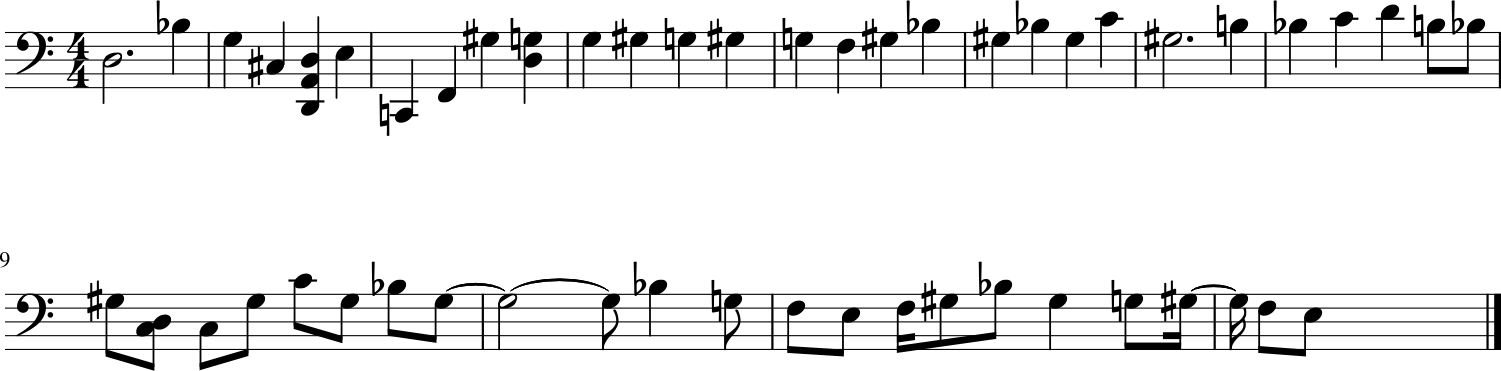

107/107 [==============================] - 85s 797ms/step - loss: 2.9508 - note_outputs_loss: 2.3653 - duration_outputs_loss: 0.5855
Epoch 9/50
107/107 [==============================] - ETA: 0s - loss: 2.8917 - note_outputs_loss: 2.3206 - duration_outputs_loss: 0.5712

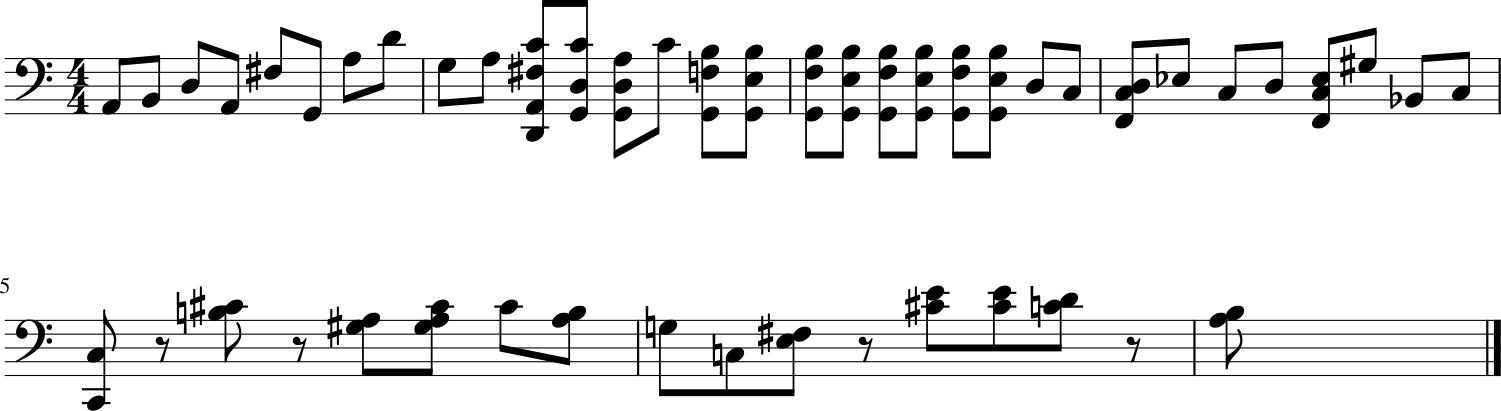

107/107 [==============================] - 83s 775ms/step - loss: 2.8917 - note_outputs_loss: 2.3206 - duration_outputs_loss: 0.5712
Epoch 10/50
107/107 [==============================] - ETA: 0s - loss: 2.8509 - note_outputs_loss: 2.2708 - duration_outputs_loss: 0.5801

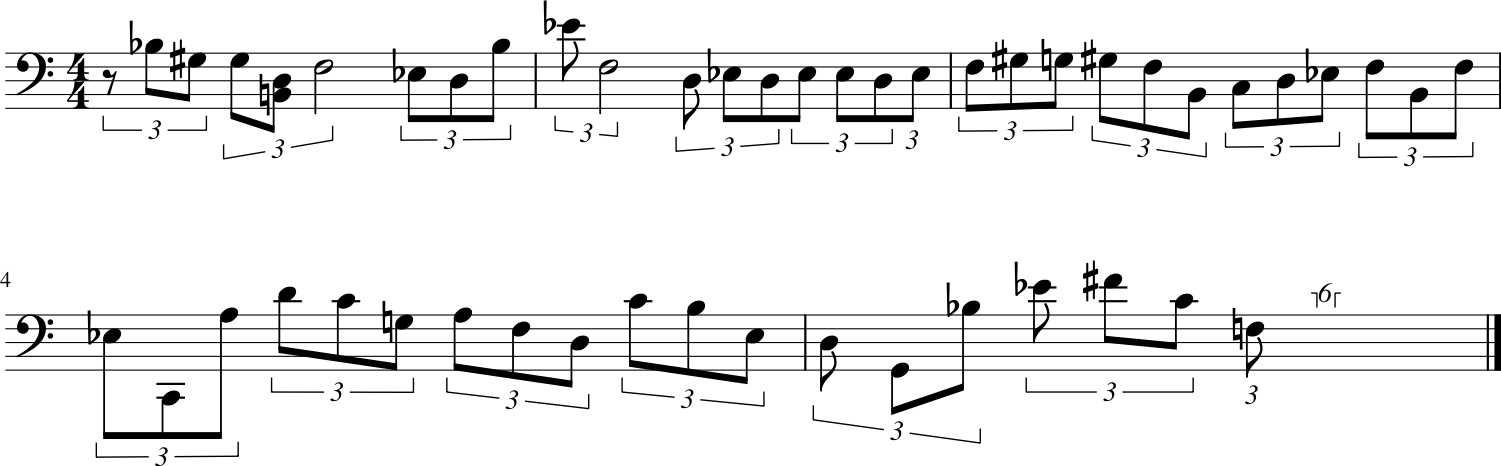

107/107 [==============================] - 81s 754ms/step - loss: 2.8509 - note_outputs_loss: 2.2708 - duration_outputs_loss: 0.5801
Epoch 11/50
107/107 [==============================] - ETA: 0s - loss: 2.7841 - note_outputs_loss: 2.2087 - duration_outputs_loss: 0.5754

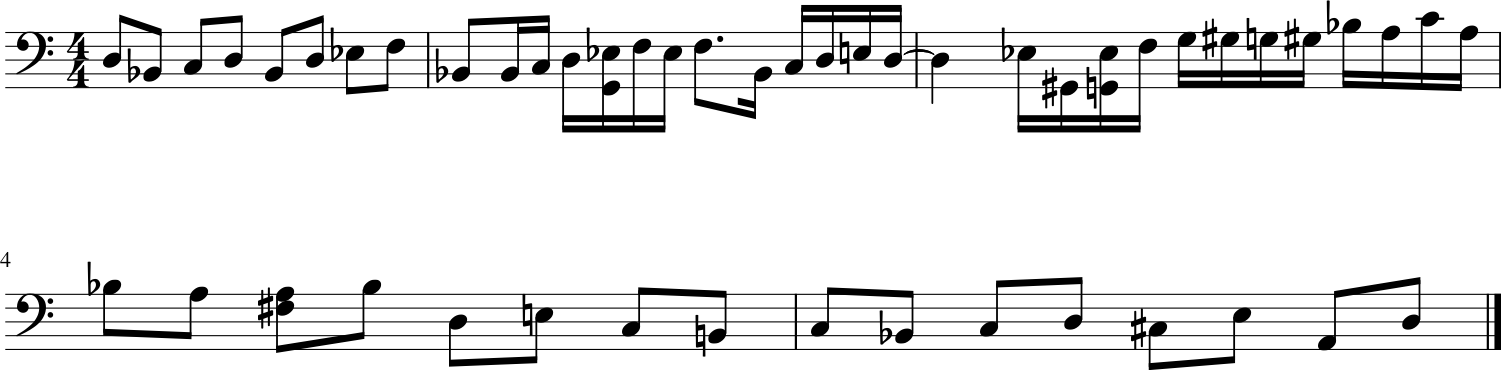

107/107 [==============================] - 81s 759ms/step - loss: 2.7841 - note_outputs_loss: 2.2087 - duration_outputs_loss: 0.5754
Epoch 12/50
107/107 [==============================] - ETA: 0s - loss: 2.7429 - note_outputs_loss: 2.1610 - duration_outputs_loss: 0.5819

In [ ]:
model.fit(
    ds,
    epochs=EPOCHS, 
    # steps_per_epoch = 3,
    callbacks = [model_checkpoint_callback, tensorboard_callback, music_generator]
)

In [ ]:
# Save the final model
model.save("./models/model")

# 3. Generate music using the Transformer

In [81]:
def print_probs(info, notes_vocab, top_k = 5):
    for i in info:
        highlighted_text = []
        for note, att_score in zip(i['prompt'][0], np.mean(i['atts'], axis = 0)):
            highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(att_score / max(np.mean(i['atts'], axis = 0)) ) + ');">' + note + '</span>')
        highlighted_text = ' '.join(highlighted_text)
        display(HTML(highlighted_text))
        
        note_probs = i['note_probs']
        p_sorted = np.sort(note_probs)[::-1][:top_k]
        i_sorted = np.argsort(note_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f'{notes_vocab[i]}:   \t{np.round(100*p,2)}%') 
        print('--------\n')

In [82]:
info = music_generator.generate(["START"], ["0"], max_tokens = 5, temperature = 1.0)


In [83]:
info[0]['prompt']

[['START'], ['0']]

In [84]:
print_probs(info, notes_vocab)

G2:   	85.84%
C3:   	5.32%
B2:   	2.99%
D3:   	2.31%
B-2:   	0.82%
--------



D3:   	99.24%
G2:   	0.17%
B-2.F3.D4:   	0.16%
C3:   	0.12%
F2:   	0.11%
--------



B3:   	99.27%
G3:   	0.7%
E3:   	0.02%
G2:   	0.01%
G2.D3.B3:   	0.0%
--------



A3:   	99.99%
D3:   	0.01%
C4:   	0.0%
G2:   	0.0%
A2.E3.C#4:   	0.0%
--------



In [85]:
midi_stream = info[-1]['midi'].chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write("midi", fp=os.path.join('/app/notebooks/music/bach-cello/output', "output-" + timestr + ".mid"))

'/app/notebooks/music/bach-cello/output/output-20221024-163511.mid'